In [1]:
# Import relevant libraries

In [2]:
import sqlite3
from sqlite3 import OperationalError
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sqlalchemy import select, func
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
os.getcwd()

'/Users/nicholas/Documents/ST2195/Coursework/dataverse_files'

In [4]:
# Establishing connection

conn = sqlite3.connect('flights_r.db')
conn.text_factory = lambda b: b.decode(errors = 'ignore')

In [5]:
# Create tables in the database

airport = pd.read_csv('airports.csv')
plane = pd.read_csv('plane-data.csv')
carrier = pd.read_csv('carriers.csv')

# Import data from dataframe into tables

airport.to_sql('airports.csv', con = conn, index = False)
plane.to_sql('plane-data.csv', con = conn, index = False)
carrier.to_sql('carriers.csv', con = conn, index = False)

ValueError: Table 'airports.csv' already exists.

In [8]:
c = conn.cursor()

In [9]:
c.execute('''
CREATE TABLE ontime (
Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')

conn.commit()

OperationalError: table ontime already exists

In [10]:
# Iterate over each year from 1997 to 2006 to read data from compressed .bz2 files
for year in range(1997, 2007):
    filename = str(year)+".csv.bz2"
    print('Processing:', filename)
    ontime = pd.read_csv(filename, encoding="latin-1", compression='bz2') #avoids UnicodeDecodeError
    ontime.to_sql('ontime', con = conn, if_exists = 'append', index = False)

conn.commit()

Processing: 1997.csv.bz2
Processing: 1998.csv.bz2
Processing: 1999.csv.bz2
Processing: 2000.csv.bz2
Processing: 2001.csv.bz2
Processing: 2002.csv.bz2
Processing: 2003.csv.bz2


/var/folders/01/3j1np7y50gv_96486sdhthqw0000gn/T/ipykernel_32518/1525908073.py:5: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  ontime = pd.read_csv(filename, encoding="latin-1", compression='bz2') #avoids UnicodeDecodeError


Processing: 2004.csv.bz2
Processing: 2005.csv.bz2
Processing: 2006.csv.bz2


In [6]:
# Get the list of tables in the database
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = c.fetchall()

In [7]:
# Iterate through the tables and print their names and column names
for table in tables:
    table_name = table[0]
    print("Table:", table_name)
    c.execute("PRAGMA table_info('{}');".format(table_name))
    columns = c.fetchall()
    print("Columns:")
    for column in columns:
        print(column[1])

Table: airports
Columns:
iata
airport
city
state
country
lat
long
Table: carriers
Columns:
Code
Description
Table: planes
Columns:
tailnum
type
manufacturer
issue_date
model
status
aircraft_type
engine_type
year
Table: flights
Columns:
Year
Month
DayofMonth
DayOfWeek
DepTime
CRSDepTime
ArrTime
CRSArrTime
UniqueCarrier
FlightNum
TailNum
ActualElapsedTime
CRSElapsedTime
AirTime
ArrDelay
DepDelay
Origin
Dest
Distance
TaxiIn
TaxiOut
Cancelled
CancellationCode
Diverted
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
Table: airports.csv
Columns:
iata
airport
city
state
country
lat
long
Table: plane-data.csv
Columns:
tailnum
type
manufacturer
issue_date
model
status
aircraft_type
engine_type
year
Table: carriers.csv
Columns:
Code
Description
Table: ontime
Columns:
Year
Month
DayofMonth
DayOfWeek
DepTime
CRSDepTime
ArrTime
CRSArrTime
UniqueCarrier
FlightNum
TailNum
ActualElapsedTime
CRSElapsedTime
AirTime
ArrDelay
DepDelay
Origin
Dest
Distance
TaxiIn
TaxiOut
Cancelled
Cancel

# Part A Query

In [8]:
# Calculates avg delay for flights based on departure times categorized into specific time intervals
# Data are then grouped by year, day of the week, and time interval
query = """
    SELECT 
        Year,
        dayofweek,
        CASE 
            WHEN deptime BETWEEN 0 AND 359 THEN '0000-0359'
            WHEN deptime BETWEEN 400 AND 759 THEN '0400-0759'
            WHEN deptime BETWEEN 800 AND 1159 THEN '0800-1159'
            WHEN deptime BETWEEN 1200 AND 1559 THEN '1200-1559'
            WHEN deptime BETWEEN 1600 AND 1959 THEN '1600-1959'
            WHEN deptime BETWEEN 2000 AND 2359 THEN '2000-2359'
        END AS time_interval,  
        AVG(depdelay) AS avg_delay
    FROM flights
    WHERE year BETWEEN 1997 AND 2006 AND deptime <= '2359'
    GROUP BY Year, dayofweek, time_interval
"""

In [9]:
# Execute the query and store the result in a DataFrame
c.execute(query)
columns = [desc[0] for desc in c.description]
q1 = pd.DataFrame(c.fetchall(), columns=columns)

In [10]:
# View results and summary of q1
print(q1)
print(q1.describe())

     Year  DayOfWeek time_interval  avg_delay
0    1997          1     0000-0359  18.362853
1    1997          1     0400-0759   1.310426
2    1997          1     0800-1159   5.107982
3    1997          1     1200-1559   6.719039
4    1997          1     1600-1959   8.656504
..    ...        ...           ...        ...
415  2006          7     0400-0759  -0.975671
416  2006          7     0800-1159   3.293947
417  2006          7     1200-1559   8.655979
418  2006          7     1600-1959  14.794808
419  2006          7     2000-2359  28.814012

[420 rows x 4 columns]
              Year   DayOfWeek   avg_delay
count   420.000000  420.000000  420.000000
mean   2001.500000    4.000000   14.767436
std       2.875707    2.002385   16.521385
min    1997.000000    1.000000   -1.792491
25%    1999.000000    2.000000    3.902442
50%    2001.500000    4.000000    9.135097
75%    2004.000000    6.000000   19.871817
max    2006.000000    7.000000   81.292358


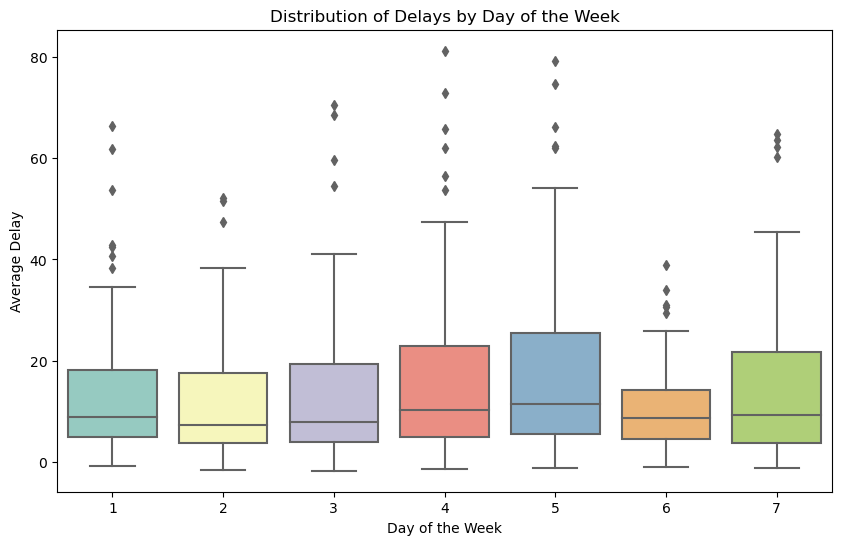

In [11]:
# Produce boxplot showing distribution of delay for each day of the week
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='avg_delay', data=q1, palette='Set3')
plt.title('Distribution of Delays by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay')
plt.show()

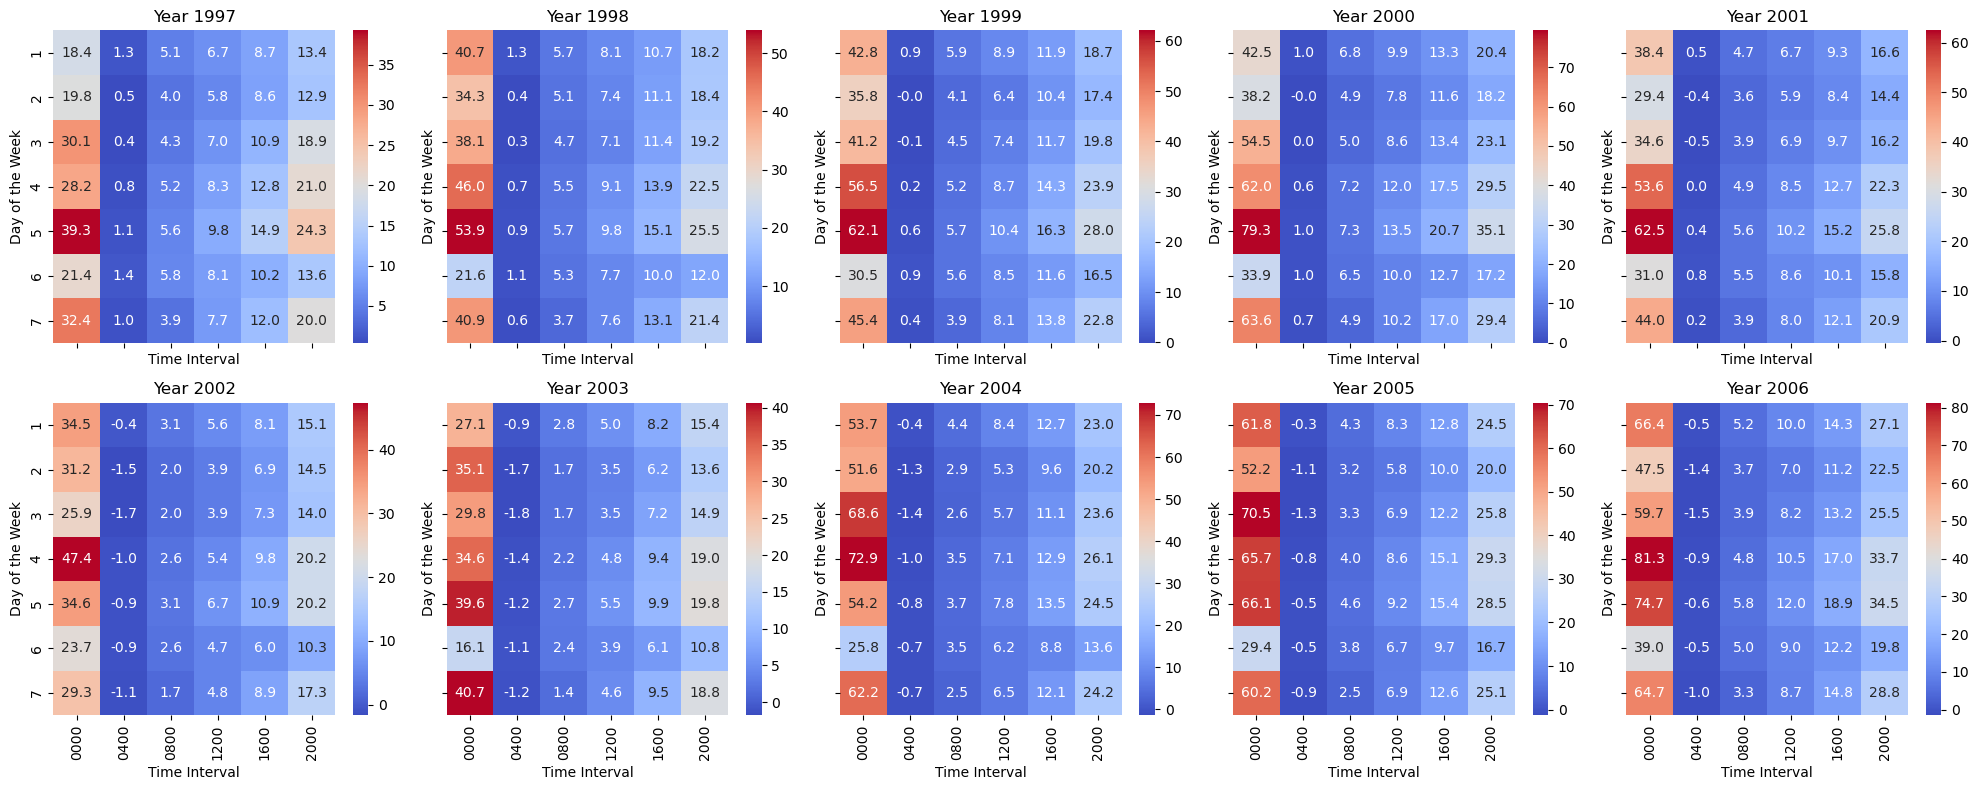

In [12]:
# Create subplots for each year
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
years = range(1997, 2007)

for i, year in enumerate(years):
    ax = axes[i // 5, i % 5]
    heatmap_data = q1[q1['Year'] == year].pivot_table(index='DayOfWeek', columns='time_interval', values='avg_delay')
    if heatmap_data.empty:
        print(f"No data for Year {year}. Skipping...")
        continue
    sns.heatmap(data=heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", ax=ax)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Time Interval')
    ax.set_ylabel('Day of the Week')
    ax.set_xticklabels(['0000', '0400', '0800', '1200', '1600', '2000'])

plt.tight_layout()

# Part B Query

In [13]:
# Query to calculate age of planes according to each year of flight
query = """
    SELECT 
        (f.year - p.year) AS plane_age,
        AVG(f.depdelay) AS avg_delay
    FROM 
        flights AS f
    INNER JOIN 
        planes AS p ON f.tailnum = p.tailnum
    WHERE 
        f.depdelay IS NOT NULL
        AND p.year IS NOT NULL
        AND p.year NOT IN ('', 'None', '0000')
        AND (f.year - p.year) >= 0
        AND LENGTH(p.year) = 4
    GROUP BY 
        plane_age
"""

In [14]:
# Fetch data into a pandas DataFrame
q2 = pd.read_sql_query(query, conn)

In [15]:
# Calculate correlation coefficient
correl = q2['plane_age'].corr(q2['avg_delay'])
print(correl)

-0.38621466775207114


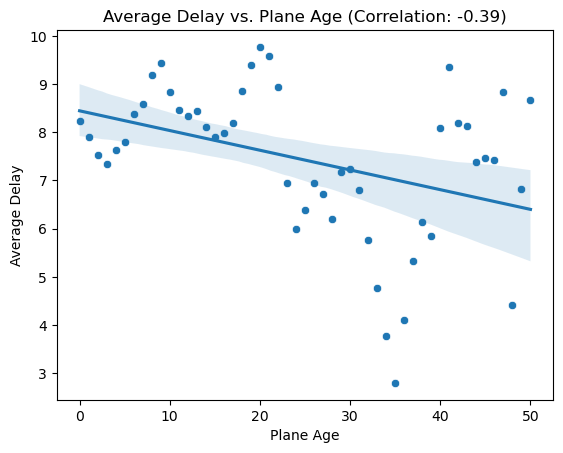

In [16]:
# Create scatter plot with trend line
sns.scatterplot(data=q2, x='plane_age', y='avg_delay')
sns.regplot(data=q2, x='plane_age', y='avg_delay', scatter=False)
plt.title(f'Average Delay vs. Plane Age (Correlation: {correl:.2f})')
plt.xlabel('Plane Age')
plt.ylabel('Average Delay')
plt.show()

# Part C Query

In [17]:
# Load data with filtering invalid 'TailNum' values
flights_query = "SELECT * FROM flights WHERE TailNum NOT LIKE '%@@%' ORDER BY RANDOM() LIMIT 50000"
flights = pd.read_sql_query(flights_query, conn)

# Load other data without modification
planes_query = "SELECT * FROM planes"
planes = pd.read_sql_query(planes_query, conn)

carriers_query = "SELECT * FROM carriers"
carriers = pd.read_sql_query(carriers_query, conn)

airports_query = "SELECT * FROM airports"
airports = pd.read_sql_query(airports_query, conn)

In [18]:
# Merge relevant dataframes
flights = flights.merge(planes, left_on='TailNum', right_on='tailnum', how='left')
flights = flights.merge(carriers, left_on='UniqueCarrier', right_on='Code', how='left')
flights = flights.merge(airports, left_on='Origin', right_on='iata', how='left')
flights.rename(columns={'long': 'origin_long', 'lat': 'origin_lat'}, inplace=True)
flights = flights.merge(airports, left_on='Dest', right_on='iata', how='left')
flights.rename(columns={'long': 'dest_long', 'lat': 'dest_lat'}, inplace=True)

In [19]:
# Feature engineering
flights['Distance'] = np.sqrt((flights['dest_lat'] - flights['origin_lat']) ** 2 + (flights['dest_long'] - flights['origin_long']) ** 2)

# Select relevant features
features = ['CRSDepTime', 'CRSArrTime', 'Distance']

In [20]:
# Fill missing values
flights[features] = flights[features].fillna(0)

In [21]:
# Fit logistic regression models for each year
coefficients = {}
models = {}
for year in range(1997, 2007):
    X = flights[flights['Year'] == year][features]
    y = (flights[flights['Year'] == year]['Diverted'] == 1).astype(int)
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    
    # Store coefficients and fitted model
    coefficients[year] = model.coef_[0]
    models[year] = {'model': model, 'coefficients': model.coef_[0]}

In [22]:
# View the fitted models
for year, coefficients_info in coefficients.items():
    print(f"Year: {year}")
    print("Coefficients:")
    for feature, coefficient in zip(features, coefficients_info):
        print(f"{feature}: {coefficient}")
    print("="*50)

Year: 1997
Coefficients:
CRSDepTime: 0.014525614727870584
CRSArrTime: 0.46340478464835455
Distance: 0.2703827668524646
Year: 1998
Coefficients:
CRSDepTime: 0.1040483728223451
CRSArrTime: -0.25841460089766344
Distance: 0.3028382197850656
Year: 1999
Coefficients:
CRSDepTime: 0.4371123399081512
CRSArrTime: 1.056931787654161
Distance: 0.2984673418715679
Year: 2000
Coefficients:
CRSDepTime: -0.5676699554987975
CRSArrTime: 0.8487632509863001
Distance: 0.23662187855262246
Year: 2001
Coefficients:
CRSDepTime: 0.04420145664943213
CRSArrTime: 0.28857921296987715
Distance: -0.1963006699016731
Year: 2002
Coefficients:
CRSDepTime: -0.31862726406326025
CRSArrTime: 0.833046502208684
Distance: 0.12358363325375392
Year: 2003
Coefficients:
CRSDepTime: -0.39128055000305956
CRSArrTime: 0.3246567716189564
Distance: -0.30932642015792483
Year: 2004
Coefficients:
CRSDepTime: -0.5920831451852181
CRSArrTime: 0.25039927409005863
Distance: 0.012983574577446654
Year: 2005
Coefficients:
CRSDepTime: 0.31313601249458

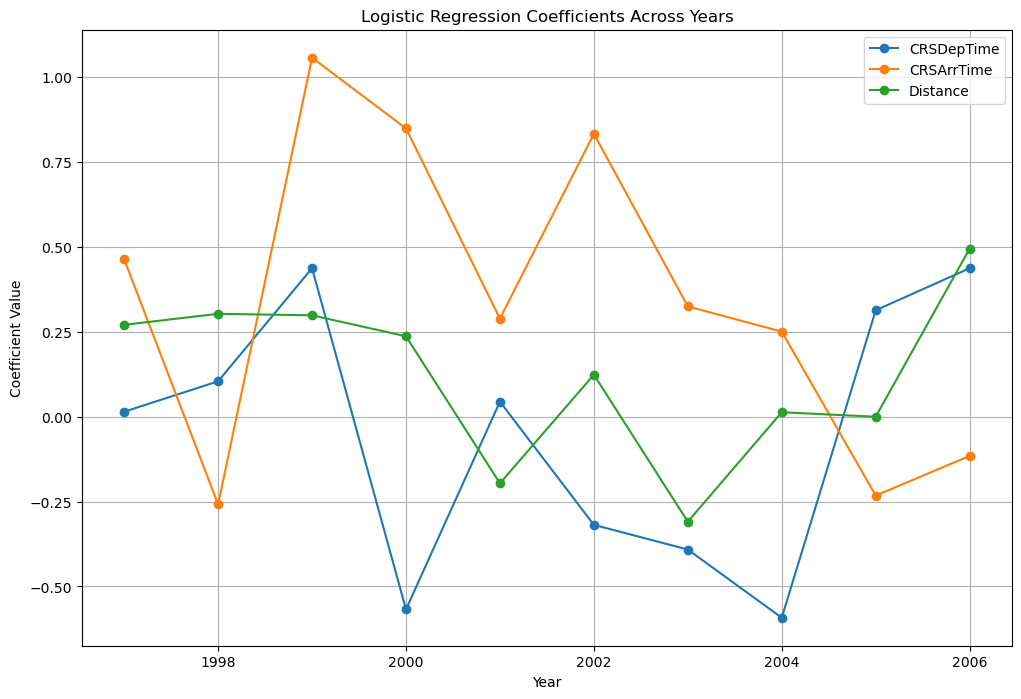

In [23]:
# Create a plot for each feature
plt.figure(figsize=(12, 8))

for feature in features:
    # Extract coefficient values for the feature across years
    coefficient_values = [coefficients[year][features.index(feature)] for year in range(1997, 2007)]
    
    # Plot coefficient values against years
    plt.plot(range(1997, 2007), coefficient_values, marker='o', label=feature)

# Add labels and title
plt.title('Logistic Regression Coefficients Across Years')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()